In [1]:
dir_data = '../data/skin-cancer'
dir_ckpt = './outputs/ckpt'

seed = 0
method = 'persistence-landscape'
n_layers = 1
n_bins = 100

n_classes = 7
input_shape = {'img': (28, 28, 1), 'tda': (n_bins, 2)}

In [2]:
import sys
sys.path.append('../')

from cnntdanet.utils import seed_all
from cnntdanet.tda import get_tda_pipeline
from cnntdanet.models import get_cnn_net, get_wide_cnn_net, get_cnn_tda_net
from cnntdanet.utils.plotting import plot_learning_curve
from cnntdanet.gradcam import GradCAMOnCNN, GradCAMOnCNNTDANet

import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

In [3]:
seed_all(seed)

In [4]:
# Preparing dataset
df = pd.read_csv(os.path.join(dir_data, 'hmnist_28_28_L.csv'))

X = df.drop('label', axis=1).values.reshape((-1, *input_shape['img']))
X = X.astype(np.float32)
X /= 255.0

y = df['label'].values
y = y.astype(np.int64)

## TDA features
pipeline = get_tda_pipeline(method=method, n_bins=n_bins, n_layers=n_layers)

X_tda = pipeline.fit_transform(X)
X_tda = X_tda.astype(np.float32)

In [5]:
# Splitting data
y_ = y.copy()  # For stratification

train_indices, valid_indices = train_test_split(np.arange(len(X)), stratify=y_, test_size=0.2, random_state=seed)

## One-hot encoding
y = tf.keras.utils.to_categorical(y_, n_classes) 

X_img_train, X_tda_train, y_train = X[train_indices], X_tda[train_indices], y[train_indices]
X_img_valid, X_tda_valid, y_valid = X[valid_indices], X_tda[valid_indices], y[valid_indices]

In [6]:
# Build a single 2D-CNN network
cnn = get_cnn_net(input_shape=input_shape['img'], n_classes=n_classes)

# Define a loss function, an optimization method, and evaluate metrics
cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

# Train the model
history = cnn.fit(
    X_img_train, y_train,
    validation_split=0.2,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)],
    epochs=20
)


Epoch 1/20


2023-05-18 14:16:48.848028: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


201/201 [==============================] - 2s 5ms/step - loss: 1.1777 - acc: 0.6634 - val_loss: 1.1114 - val_acc: 0.6862
Epoch 2/20
201/201 [==============================] - 1s 4ms/step - loss: 1.0769 - acc: 0.6653 - val_loss: 0.9645 - val_acc: 0.6862
Epoch 3/20
201/201 [==============================] - 1s 4ms/step - loss: 1.0116 - acc: 0.6663 - val_loss: 0.9271 - val_acc: 0.6918
Epoch 4/20
201/201 [==============================] - 1s 4ms/step - loss: 0.9714 - acc: 0.6762 - val_loss: 1.0555 - val_acc: 0.6818
Epoch 5/20
201/201 [==============================] - 1s 4ms/step - loss: 0.9455 - acc: 0.6770 - val_loss: 0.8938 - val_acc: 0.7093
Epoch 6/20
201/201 [==============================] - 1s 4ms/step - loss: 0.9139 - acc: 0.6833 - val_loss: 0.8461 - val_acc: 0.7112
Epoch 7/20
201/201 [==============================] - 1s 4ms/step - loss: 0.8895 - acc: 0.6912 - val_loss: 0.8320 - val_acc: 0.7162
Epoch 8/20
201/201 [==============================] - 1s 4ms/step - loss: 0.8707 - acc:

In [7]:
history_cnn = history.history

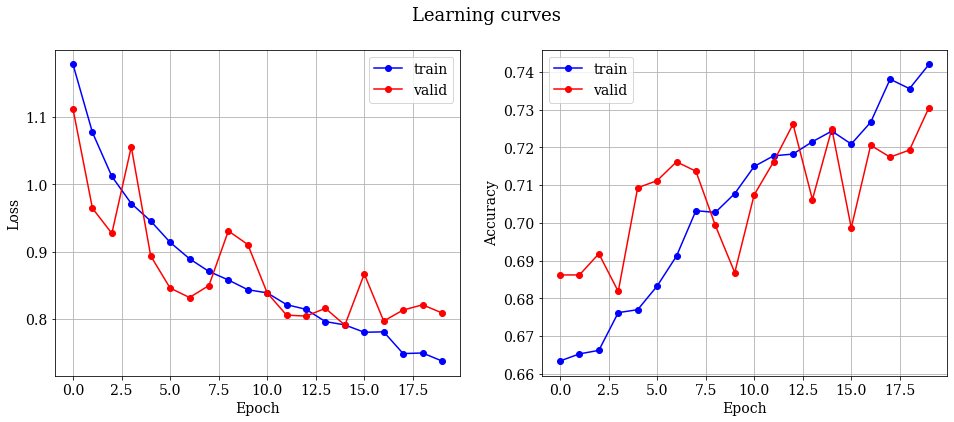

In [8]:
plot_learning_curve(history.history)

In [9]:
y_true = np.argmax(y_valid, axis=1) # From one-hot encoding to label
y_pred = cnn.predict(X_img_valid)  # Make predictions
y_pred = np.argmax(y_pred, axis=1)  # Take the maximum probability for each prediction

print(f"Accuracy  : {100 * accuracy_score(y_true, y_pred):.2f}")
print(f"Recall    : {100 * recall_score(y_true, y_pred, average='macro'):.2f}")
print(f"Precision : {100 * precision_score(y_true, y_pred, average='weighted', zero_division=0):.2f}")
print(f"F1        : {100 * f1_score(y_true, y_pred, average='weighted', zero_division=0):.2f}")

Accuracy  : 72.69
Recall    : 28.43
Precision : 67.33
F1        : 68.60


In [10]:
# Build a single 2D-CNN network
cnn_tda = get_cnn_tda_net(method=method, input_shape=input_shape, n_classes=n_classes)
# Define a loss function, an optimization method, and evaluate metrics
cnn_tda.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
# Train the model
history = cnn_tda.fit(
    [X_img_train, X_tda_train], y_train,
    validation_split=0.2,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)],
    epochs=20
)

Epoch 1/20
201/201 [==============================] - 3s 8ms/step - loss: 1.0833 - acc: 0.6608 - val_loss: 1.2917 - val_acc: 0.6862
Epoch 2/20
201/201 [==============================] - 1s 7ms/step - loss: 0.9886 - acc: 0.6719 - val_loss: 0.9441 - val_acc: 0.6862
Epoch 3/20
201/201 [==============================] - 1s 7ms/step - loss: 0.9285 - acc: 0.6769 - val_loss: 0.8565 - val_acc: 0.7031
Epoch 4/20
201/201 [==============================] - 1s 7ms/step - loss: 0.9120 - acc: 0.6828 - val_loss: 1.0253 - val_acc: 0.6681
Epoch 5/20
201/201 [==============================] - 2s 8ms/step - loss: 0.9029 - acc: 0.6859 - val_loss: 0.8425 - val_acc: 0.7124
Epoch 6/20
201/201 [==============================] - 1s 7ms/step - loss: 0.8846 - acc: 0.6909 - val_loss: 0.8473 - val_acc: 0.7099
Epoch 7/20
201/201 [==============================] - 1s 7ms/step - loss: 0.8752 - acc: 0.6998 - val_loss: 0.8443 - val_acc: 0.7162
Epoch 8/20
201/201 [==============================] - 1s 7ms/step - loss: 0.

In [11]:
history_cnn_tda = history.history

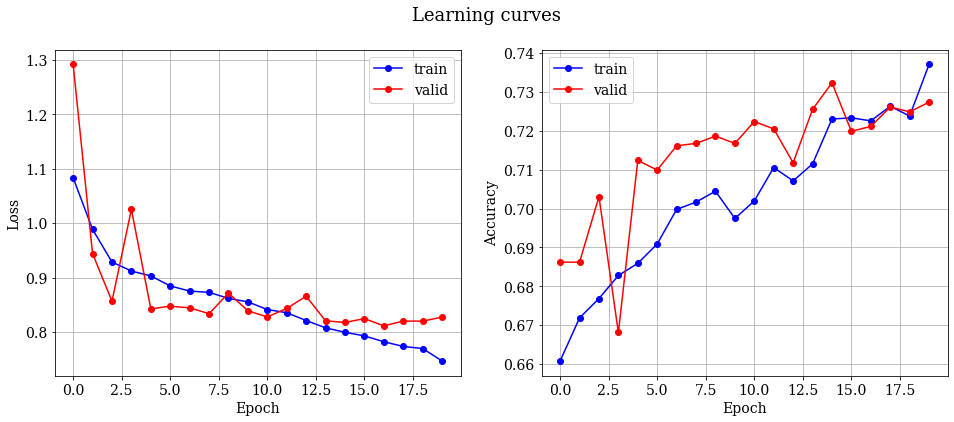

In [12]:
plot_learning_curve(history.history)

In [13]:
y_true = np.argmax(y_valid, axis=1) # From one-hot encoding to label
y_pred = cnn_tda.predict([X_img_valid, X_tda_valid])  # Make predictions
y_pred = np.argmax(y_pred, axis=1)  # Take the maximum probability for each prediction

print(f"Accuracy  : {100 * accuracy_score(y_true, y_pred):.2f}")
print(f"Recall    : {100 * recall_score(y_true, y_pred, average='macro'):.2f}")
print(f"Precision : {100 * precision_score(y_true, y_pred, average='weighted', zero_division=0):.2f}")
print(f"F1        : {100 * f1_score(y_true, y_pred, average='weighted', zero_division=0):.2f}")

Accuracy  : 71.49
Recall    : 30.49
Precision : 66.94
F1        : 67.81


In [17]:
def filtration_to_image(img, filt_start, filt_end=None):
    if filt_end is None:
        mask = np.where(img != filt_start)
        
    else:
        mask = np.where((img < filt_start) | (img >= filt_end))
        
    inverse_img = img.copy()
    inverse_img[mask] = 0
    
    return inverse_img
        
    
def get_inverse_image(cache, l):
    img = cache['img'] / 255.0
    heatmap = cache['heatmap'][1][:, 0]
    argmax = np.argmax(heatmap)
    filt_start = max(0, argmax - l) / len(heatmap)
    filt_end = min(len(heatmap), argmax + 1) / len(heatmap)
    
    img_recovered = filtration_to_image(img, filt_start, filt_end)
    
    return img_recovered

In [120]:
alpha = 0.7
dir_figure = './outputs/figures'
gradcam_cnn = GradCAMOnCNN(cnn, layer_name='conv2d_3')
gradcam_cnn_tda = GradCAMOnCNNTDANet(cnn_tda, local_layer_name='conv2d_8', global_layer_name='conv1d_8')
indices = [25, 169, 0, 103]
for i, idx in enumerate(indices):
    # Sample
    img = X_img_valid[idx:idx+1]
    tda = X_tda_valid[idx:idx+1]
    label = np.argmax(y_valid, axis=1)[idx]

    # Original image
    fig = plt.figure(figsize=(4, 4), frameon=False)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    fig.set_size_inches(4, 4)
    ax.imshow(img[0, :, :, 0], cmap='gray')
    ax.set_axis_off()
    fig.add_axes(ax)
    plt.savefig(os.path.join(dir_figure, f'figureB1a_{i+1}r.pdf'), dpi=100)
    plt.cla()
    plt.clf()
    plt.close()

    # Grad-CAM of the single CNN
    gradcam_cnn.to_heatmap(img)
    fig = plt.figure(figsize=(4, 4), frameon=False)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    fig.set_size_inches(4, 4)
    ax.imshow(img[0, :, :, 0], cmap='gray')
    ax.imshow(gradcam_cnn._cache['heatmap'][0], cmap='jet', alpha=alpha)
    ax.set_axis_off()
    fig.add_axes(ax)
    plt.savefig(os.path.join(dir_figure, f'figureB1b_{i+1}r.pdf'), dpi=100)
    plt.cla()
    plt.clf()
    plt.close()

    # Grad-CAM of the CNN-PL Net's image network
    gradcam_cnn_tda.to_heatmap([img, tda])
    fig = plt.figure(figsize=(4, 4), frameon=False)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    fig.set_size_inches(4, 4)
    ax.imshow(img[0, :, :, 0], cmap='gray')
    ax.imshow(gradcam_cnn_tda._cache['heatmap'][0], cmap='jet', alpha=alpha)
    ax.set_axis_off()
    fig.add_axes(ax)
    plt.savefig(os.path.join(dir_figure, f'figureB1c_{i+1}r.pdf'), dpi=100)
    plt.cla()
    plt.clf()
    plt.close()

    # Inverse image
    img_recovered = get_inverse_image(gradcam_cnn_tda._cache, l=32)
    fig = plt.figure(figsize=(4, 4), frameon=False)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    fig.set_size_inches(4, 4)
    ax.imshow(img_recovered, cmap='gray')
    ax.set_axis_off()
    fig.add_axes(ax)
    plt.savefig(os.path.join(dir_figure, f'figureB1d_{i+1}r.pdf'), dpi=100)
    plt.cla()
    plt.clf()
    plt.close()

    # Grad-CAM of the CNN-PL Net's topology network
    cache2 = gradcam_cnn_tda._cache
    fig = plt.figure(figsize=(4, 4), frameon=False)
    fig.set_size_inches(4, 4)
    ax = plt.Axes(fig, [0., 0., 1., 1.])

    ax.plot(cache2['tda'][:, 0], 'b', label='dim0')
    ax.plot(cache2['tda'][:, 1], 'r', label='dim1')
    ax.set_yticklabels('')
    ax.set_xticklabels('')
    ax.legend(loc=2); ax.grid();
    fig.add_axes(ax)

    ax_mat = fig.add_axes([0.043, -0.3293, 0.91, 0.7])
    mat = ax_mat.matshow(cache2['heatmap'][1].T, cmap='jet')
    ax_mat.axis('off')

    cax = fig.add_axes([1.01, 0.00, 0.03, 1.0])
    fig.colorbar(mat, cax=cax)

    plt.savefig(os.path.join(dir_figure, f'figureB1e_{i+1}r.pdf'), dpi=100, bbox_inches='tight')
    plt.cla()
    plt.clf()
    plt.close()

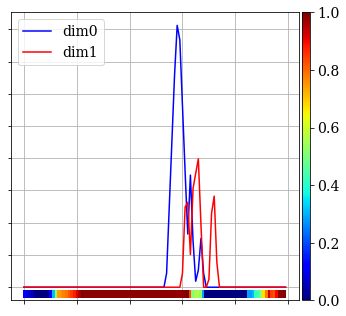

In [119]:
cache2 = gradcam_cnn_tda._cache
fig = plt.figure(figsize=(4, 4), frameon=False)
fig.set_size_inches(4, 4)
ax = plt.Axes(fig, [0., 0., 1., 1.])

ax.plot(cache2['tda'][:, 0], 'b', label='dim0')
ax.plot(cache2['tda'][:, 1], 'r', label='dim1')
ax.set_yticklabels('')
ax.set_xticklabels('')
ax.legend(loc=2); ax.grid();
fig.add_axes(ax)

ax_mat = fig.add_axes([0.043, -0.3293, 0.91, 0.7])
mat = ax_mat.matshow(cache2['heatmap'][1].T, cmap='jet')
ax_mat.axis('off')

cax = fig.add_axes([1.01, 0.00, 0.03, 1.0])
fig.colorbar(mat, cax=cax)